## Notes: 
line of thinking
documented motivation
understand what er are doing


proprocess 3 subjects and provide/document the cleaning times / bad channels, document the bad components

- Preprocessing Filtering, re-referencening, ICA
- Data cleaning: Time, channel and subjects
- ERP peak analysis Extract the study-relevant ERP peak subjectwise (e.g. one value per subject) and statistically test them. RQ: On which ERP-peaks do we find major difference between the conditions?
- Time Frequency analysis Calculate an induced time-frequency analysis of the main experimental contrast RQ: What oscillations underley our effect of interest?
- either:	- Mass Univariate Use a multiple regression of the main experimental contrast, controlling for reaction time (you need to calculate RT yourself). RQ: When/Where do we find differences between our conditions? Is there an influence of reaction time?
		OR
		- Decoding analysis Decode the main contrast of the experiment across time RQ: When is information about the conditions in our data available?

## Dataset Summary and Exploration
P300: A visual oddball experiment with a prolonged effect at 300ms.

In [1]:
"""
import libraries
"""
import mne
import ccs_eeg_utils
import mne  # read raw
from mne_bids import BIDSPath, read_raw_bids
import matplotlib.pyplot as plt
import matplotlib
import os  # make dir
from config import *

from matplotlib.pyplot import figure

matplotlib.use("Agg")
#%matplotlib inline

import numpy as np

In [2]:
"""
for source space
"""
from mne.viz import plot_alignment


In [3]:
def band_pass_filtering(raw, subject_id):
    """
    applys the firwin banpassfilter
    """
    print("filtering ...")

    # plot raw data before band-pass filtering
    raw.plot_psd(
        area_mode="range",
        tmax=10.0,
        average=False,
        xscale="linear",
    )
    ccs_eeg_utils.save_plot("01freq_before_filtering", bids_path)

    # apply filter
    raw_f = raw.copy().filter(l_freq, h_freq, fir_design=fir_design)
    raw_f.plot_psd(area_mode="range", tmax=10.0, average=False, xscale="log")
    ccs_eeg_utils.save_plot("02freq_after_filtering", bids_path)

    raw.set_montage("standard_1020", match_case=False)

    return raw_f

In [4]:
def plot_each_channel(subject_id):
    """
    plot data
    """
    print("plotting each channel ...")

    # create dir to save plots if not existent
    if not os.path.exists(str(str(bids_path)[:-37] + "results/03whole_overlay/")):
        os.makedirs(str(str(bids_path)[:-37] + "results/03whole_overlay/"))

    # Extract a single channel and plot the whole timeseries.
    for channel_number in range(1, len(raw.ch_names)):  # 1

        # show filtered -> low frequencies
        fig = plt.figure()
        a1 = fig.add_axes([0, 0, 1, 1])
        a1.plot((raw[channel_number - 1][0].T))
        a1.plot((raw_f[channel_number - 1][0].T))
        a1.legend(["raw", "band-pass filtered"])
        plt.title("Subject: " + str(subject_id) + ", channel: " + str(channel_number))
        plt.ylabel("potential [µV]")
        plt.xlabel("sample")
        # a1.set_xlim(0,25)
        # a1.set_ylim(-0.00003,0.00003)
        plt.savefig(
            str(
                str(bids_path)[:-37]
                + "results/03whole_overlay/channel"
                + str(channel_number)
                + ".png"
            ),
            bbox_inches="tight",
        )
        # plt.show()
        plt.close()  # don't display figure

    # show raw -> high frequnecies
    channel_number = 1
    fig = plt.figure()
    a1 = fig.add_axes([0, 0, 1, 1])
    a1.plot((raw[channel_number - 1][0].T))
    a1.plot((raw_f[channel_number - 1][0].T))
    a1.legend(["raw", "band-pass filtered"])
    plt.title("Subject: " + str(subject_id) + ", channel: " + str(channel_number))
    plt.ylabel("potential [µV]")
    plt.xlabel("sample")
    a1.set_xlim(0, 25)
    a1.set_ylim(0.0199, 0.01993)
    ccs_eeg_utils.save_plot("04zoom_raw", bids_path)
    plt.close()  # don't display figure

    # show filtered -> high frequnecies are filtered
    fig = plt.figure()
    a1 = fig.add_axes([0, 0, 1, 1])
    a1.plot((raw[channel_number - 1][0].T))
    a1.plot((raw_f[channel_number - 1][0].T))
    a1.legend(["raw", "band-pass filtered"])
    plt.title("Subject: " + str(subject_id) + ", channel: " + str(channel_number))
    plt.ylabel("potential [µV]")
    plt.xlabel("sample")
    a1.set_xlim(0, 25)
    a1.set_ylim(-0.00003, 0.00003)
    ccs_eeg_utils.save_plot("05zoom_filtered", bids_path)
    plt.close()  # don't display figure

In [5]:
def cleaning(raw_f):
    """
    TODO clean and plot
    """
    # clean manually
    #%matplotlib qt
    raw_f.plot(n_channels=len(raw_f.ch_names))

    # get bad annotations
    bad_ix = [i for i, a in enumerate(raw_f.annotations) if a["description"] == "BAD_"]

    # save bad annotations
    raw_f.annotations[bad_ix].save(
        str(str(bids_path)[:-37] + "results/badannotations.csv")
    )

    # read bad annotations
    # annotations = mne.read_annotations(str(str(bids_path)[:-37] + "results/badannotations.csv"))

    # append bad annotations
    # raw_f.annotations.append(annotations.onset,annotations.duration,annotations.description)  # duplicates

    # remove abd channels
    raw_f.info["bads"] = []

    # intepolate bad channels
    # raw_f.interpolate_bads()  # no bad channel found

    # save cleaned data
    raw.save(
        str(str(bids_path)[:-37] + "results/after_cleaning_raw.fif"), overwrite=True
    )

    # load cleaned data
    # raw_cleaned = mne.io.read_raw_fif(str(str(bids_path)[:-37] + "results/after_cleaning_raw.fif"))

    """TODO raw vs raw_f"""

    # visualize effect of cleaning on ERP
    evts, evts_dict = mne.events_from_annotations(raw)
    wanted_keys = [e for e in evts_dict.keys() if "stimulus" in e]
    evts_dict_stim = dict((k, evts_dict[k]) for k in wanted_keys if k in evts_dict)

    # get epochs with and without rejection
    epochs = mne.Epochs(
        raw, evts, evts_dict_stim, tmin=-0.1, tmax=1, reject_by_annotation=False
    )
    epochs_manual = mne.Epochs(
        raw, evts, evts_dict_stim, tmin=-0.1, tmax=1, reject_by_annotation=True
    )
    reject_criteria = dict(
        eeg=200e-6, eog=200e-6  # 100 µV # HAD TO INCREASE IT HERE, 100 was too harsh
    )  # 200 µV
    epochs_thresh = mne.Epochs(
        raw,
        evts,
        evts_dict_stim,
        tmin=-0.1,
        tmax=1,
        reject=reject_criteria,
        reject_by_annotation=False,
    )

    # compare
    mne.viz.plot_compare_evokeds(
        {
            "raw": epochs.average(),
            "clean": epochs_manual.average(),
            "thresh": epochs_thresh.average(),
        },
        picks=picked_channel,
    )
    ccs_eeg_utils.save_plot("05cleaning_compare_evoked", bids_path)


In [6]:
def ICA(raw_f_f):
    """
    ICA
    """
    print("running ICA ...")
    raw_f_f.filter(l_freq_ica, h_freq_ica, fir_design=fir_design_ica)

    # Generate an ICA object
    ica = mne.preprocessing.ICA(
        n_components=0.9999999, random_state=93, method=ica_method, max_iter=200
    )

    # fit the ICA on the data
    ica.fit(raw_f, verbose=True)

    # plot components
    ica.plot_components(picks=range(ica.n_components_ - 1))
    ccs_eeg_utils.save_plot("06ICA_components", bids_path)

    # plot properties
    # create dir to save plots if not existent

    if not os.path.exists(str(str(bids_path)[:-37] + "results/07ICA_properties/")):
        os.makedirs(str(str(bids_path)[:-37] + "results/07ICA_properties/"))
    for component in range(ica.n_components_):
        ica.plot_properties(
            raw_f, picks=component, psd_args={"fmax": 35.0}, reject=None
        )
        # save plot
        plt.savefig(
            str(
                str(bids_path)[:-37]
                + "results/07ICA_properties/component"
                + str(component)
                + ".png"
            ),
            bbox_inches="tight",
        )

        # don't display figure
        plt.close()

    """ TODO generalize for all subjects"""
    """
    # Artefacts of subject one
    heartbeat_artefacts = []
    blink_artefacts = [3]
    eye_artefacts = [0,1,2,6,24,29]
    muscle_artefacts = [5,7,10,13,16,18,21,23,28,29] # often non-stationary activity, small ERPs, "square-root spectrum", one electrode?, Yaw, below/behind ear, lowwe back of the head, 
    noisy_electrodes = [] # single active electrode, small ERP, strong 50/60hz line noise
    other_artefacts = []
    # brain components ideally show strong and clear ERPs, activity stationary over whole experiment, powerspectrum including alpha/beta peak at ~10hz, 
    """
    # Artefacts of subject two
    heartbeat_artefacts = []
    blink_artefacts = [0]
    eye_artefacts = []
    muscle_artefacts = [
        12,
        19,
        25,
    ]  # often non-stationary activity, small ERPs, "square-root spectrum", one electrode?, Yaw, below/behind ear, lowwe back of the head,
    noisy_electrodes = [
        29
    ]  # single active electrode, small ERP, strong 50/60hz line noise
    other_artefacts = [3, 7, 8, 22, 23]
    # brain components ideally show strong and clear ERPs, activity stationary over whole experiment, powerspectrum including alpha/beta peak at ~10hz,

    exclude = []
    exclude.extend(heartbeat_artefacts)
    exclude.extend(blink_artefacts)
    exclude.extend(eye_artefacts)
    exclude.extend(muscle_artefacts)
    exclude.extend(other_artefacts)
    print("excluded components:", exclude)
    ica.exclude = exclude

    # add events
    evts, evts_dict_stim = add_events(raw_f)

    # before ICA
    epochs = mne.Epochs(
        ica.get_sources(raw_f), evts, evts_dict_stim, tmin=-0.2, tmax=0.8
    )
    epochs.average(picks=picked_channel_num).plot()  # 13 for Pz?
    ccs_eeg_utils.save_plot("08" + str(picked_channel) + "_before_ICA", bids_path)

    # after ICA
    epochs = mne.Epochs(raw_f, evts, evts_dict_stim, tmin=epoch_tmin, tmax=epoch_tmax)
    epochs.average().plot(picks=picked_channel)
    ccs_eeg_utils.save_plot("09" + str(picked_channel) + "_after_ICA", bids_path)

    # before / after overlay
    reconst_raw_f = raw_f.copy()
    ica.apply(reconst_raw_f, exclude=exclude)

    # raw_f.plot()
    # reconst_raw_f.plot()
    ica.plot_overlay(raw_f, exclude=exclude)
    ccs_eeg_utils.save_plot("10before_after_overlay", bids_path)

    # save ICA
    ica.save(str(str(bids_path)[:-4] + "_chrei-ica.fif"))

In [7]:
def add_events(raw):
    """
    add events
    """
    print("adding events ...")
    evts, evts_dict = mne.events_from_annotations(raw_f)

    # get all keys which contain "stimulus"
    wanted_keys = [
        e for e in evts_dict.keys() if "stimulus" in e
    ]  # subset the large event-dictionairy

    evts_dict_stim = dict((k, evts_dict[k]) for k in wanted_keys if k in evts_dict)

    return evts, evts_dict_stim

In [8]:
def epoching():
    # Choosing Pz for P3 because this is the site most widely used in the literature and
    # recommended by Kappenman et al.
    # Cut the raw_f data to one channel using `raw_f.pick_channels(["Pz"])` -

    evts, evts_dict_stim = add_events(raw_f)

    raw_f.pick_channels([picked_channel])
    print(raw_f)
    plt.plot(raw_f[:, :][0].T)
    ccs_eeg_utils.save_plot("11" + str(picked_channel), bids_path)

    raw_f.info

    # These values reflect the values in the bids `*_events.tsv` file.
    raw_f.annotations

    # Epoch the data
    epochs = mne.Epochs(
        raw_f, evts, evts_dict_stim, tmin=epoch_tmin, tmax=epoch_tmax, baseline=baseline
    )  # tmin and tmax chosen as recommended by Kappenman et al.

    # Plot all trials
    plt.plot(np.squeeze(epochs.get_data()[:, 0, :].T))
    ccs_eeg_utils.save_plot("12trials", bids_path)

    return epochs, evts, evts_dict_stim

In [9]:
def get_peak_value(data, timestamp):
    """
    get peak values from timestamp
    """
    peak_time_index = data.time_as_index(timestamp)
    data_frame = data.to_data_frame(picks=picked_channel)
    peak_value = data_frame.at[peak_time_index[0], picked_channel]

    return peak_value

In [10]:
def create_peak_data(target_peak, distractor_peak):
    """
    create array where first column is the data and second column is the label
    where: target -> 1, distractor -> 0

    peak value | label
    -----------|------
    0.1234     | 1
    0.2345     | 0
    """

    # ini matrix with zeros
    erp_data = np.zeros(((last_subject) * 2, 2))

    # fill targets
    for row in range(last_subject):
        erp_data[row][0] = target_peak[row]  # values
        erp_data[row][1] = 1  # labels

    # fill distractors
    for row in range(last_subject):
        erp_data[row + last_subject][0] = distractor_peak[row]
        # erp_data[row+last_subject][1] = 0 # already 0s

    print("erp_data:", erp_data)
    print("erp_data.shape:", erp_data.shape)

    return erp_data

In [11]:
def erp_analysis():
    # indexing and averaging epochs
    target = epochs[["stimulus:{}{}".format(k, k) for k in [1, 2, 3, 4, 5]]].average()
    distractor = epochs[
        [
            "stimulus:{}{}".format(k, j)
            for k in [1, 2, 3, 4, 5]
            for j in [1, 2, 3, 4, 5]
            if k != j
        ]
    ].average()

    # plotting
    mne.viz.plot_compare_evokeds([target, distractor])
    ccs_eeg_utils.save_plot("13epochs_average", bids_path)

    """
    get peaks
    """
    # get peak times target
    _, peak_time_target = target.get_peak(mode="pos")  # get peak time
    print("peak_time_target:", peak_time_target)
    peak_time_target_list.append(peak_time_target)

    # get peak value target
    peak_value_target = get_peak_value(target, peak_time_target)
    print("peak_value_target:", peak_value_target)
    peak_value_target_list.append(peak_value_target)  # from epoch to evoked

    # get peak times distractor
    _, peak_time_distractor = distractor.get_peak(mode="pos")
    print("peak_time_distractor:", peak_time_distractor)
    peak_time_distractor_list.append(peak_time_distractor)

    # get peak value distractor
    peak_value_distractor = get_peak_value(distractor, peak_time_distractor)
    print("peak_value_distractor:", peak_value_distractor)
    peak_value_distractor_list.append(peak_value_distractor)

    # print(target_peak_t,distractor_peak_t)

    return (
        peak_time_target_list,
        peak_value_target_list,
        peak_time_distractor_list,
        peak_value_distractor_list,
        target,
        distractor
    )

In [12]:
str(
            
        )

''

In [13]:
def erp_differences(
    peak_target_list,
    peak_distractor_list,
    title="title",
    xlabel="xlabel",
    ylabel="# subjects",
):
    peak_difference_list = np.subtract(peak_target_list, peak_distractor_list)
    #%matplotlib inline
    _ = plt.hist(
        peak_difference_list, bins="auto"
    )  # arguments are passed to np.histogram
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.show()
    
    # save fig
    plt.savefig(
        "../intersubject_results/"+str(title)+".png",
        bbox_inches="tight",
    )
    # plt.show()
    plt.close()  # don't display figure    

    average_difference = np.average(peak_difference_list)
    meadian_difference = np.median(peak_difference_list)
    std_dev_difference = np.std(peak_difference_list)

    # print(average_difference, meadian_difference, std_dev_difference)
    return average_difference, meadian_difference, std_dev_difference

In [14]:
def permutation_test(peak_target, peak_distractor):
    # create one data array with peak values and labels
    peak_data = create_peak_data(peak_target, peak_distractor)

    # perform permutation test
    t_obs, p_values, H0 = mne.stats.permutation_t_test(peak_data, verbose=True)
    # print('t_obs:', t_obs)
    # print('p_values:', p_values)
    # print('H0:', H0)

    return t_obs, p_values

In [15]:
"""
pipeline

load data
read annotations
resample to 256 Hz
re-reference to P9 and P10
(Extract a single channel and plot the whole timeseries)
"""
# path where to save the datasets.
bids_root = "../local/bids"
last_subject

# time of peak
peak_time_target_list = []
peak_time_distractor_list = []
peak_value_target_list = []
peak_value_distractor_list = []

for subject in range(frist_subject, last_subject + 1):
    print("subject =", subject)
    subject_id = f"{subject:03}"

    bids_path = BIDSPath(
        subject=subject_id,
        task="P3",
        session="P3",
        datatype="eeg",
        suffix="eeg",
        root=bids_root,
    )

    # read the file
    raw = read_raw_bids(bids_path)

    # fix the annotations readin
    ccs_eeg_utils.read_annotations_core(bids_path, raw)

    # load data
    raw.load_data()

    # delay shift
    # todo

    # resample / downsample frequency
    raw.resample(
        sfreq, npad="auto"
    )  # set sampling frequency to 256 Hz as in Kappenman et al.

    # rerefernecing to P9 and P10 becuase Kappenman et al. says
    # "we find that P9 and P10 provide cleaner signals than the traditional mastoid sites"
    # TODO: commented out as not allowed for space localization?
    raw.set_eeg_reference(ref_channels=ref_channels, verbose=None)

    # add channel locations
    raw.set_montage("standard_1020", match_case=False)

    # band pass filtering between 0.1 and 54 hz
    raw_f = band_pass_filtering(raw, subject_id)

    # plot each channel
    # plot_each_channel(subject_id) # takes a while

    # remove large muscle artifacts, extreme voltage offsets, or break periods
    # cleaning(raw_f)

    # ICA
    # ICA(raw_f)

    epochs, evts, evts_dict_stim = epoching()

    (
        peak_time_target_list,
        peak_value_target_list,
        peak_time_distractor_list,
        peak_value_distractor_list,
        target,
        distractor
    ) = erp_analysis()

"""
inter-subject peak analysis
"""
# histograms
(
    average_time_difference,
    meadian_time_difference,
    std_dev_time_difference,
) = erp_differences(
    peak_time_target_list,
    peak_time_distractor_list,
    title="Delay of target ERP relative to distractor ERP",
    xlabel="relative delay in ms",
)
print(
    "average_time_difference: ",
    average_time_difference,
    "\nmeadian_time_difference:",
    meadian_time_difference,
    "\n std_dev_time_difference:",
    std_dev_time_difference,
)

(
    average_value_difference,
    meadian_value_difference,
    std_dev_value_difference,
) = erp_differences(
    peak_value_target_list,
    peak_value_distractor_list,
    title="Delay of target ERP relative to distractor ERP",
    xlabel="relative delay in ms",
)
print(
    "average_value_difference: ",
    average_value_difference,
    "\nmeadian_value_difference:",
    meadian_value_difference,
    "\n std_dev_value_difference:",
    std_dev_value_difference,
)

"""
permutation tests
"""
# time delay of peak
t_obs_time, p_values_time = permutation_test(
    peak_time_target_list, peak_time_distractor_list
)

# difference in peak potential
t_obs_value, p_values_value = permutation_test(
    peak_value_target_list, peak_value_distractor_list
)

"""
source space
"""


subject = 1
Reading ../local/bids/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_eeg.fdt
Reading events from ../local/bids/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_events.tsv.
Reading channel info from ../local/bids/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_channels.tsv.
Reading 0 ... 478207  =      0.000 ...   466.999 secs...


<ipython-input-15-f602f8bf5385>:34: RuntimeWarning: Data file name in EEG.data (sub-001_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-001_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-15-f602f8bf5385>:34: RuntimeWarning: Did not find any coordsystem.json associated with sub-001_ses-P3_task-P3.

The search_str was "../local/bids/sub-001/**/sub-001_ses-P3*coordsystem.json"
  raw = read_raw_bids(bids_path)


EEG channel type selected for re-referencing
Applying a custom EEG reference.
filtering ...
Effective window size : 8.000 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.4 - 54 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 54.00 Hz
- Upper transition bandwidth: 13.50 Hz (-6 dB cutoff frequency: 60.75 Hz)
- Filter length: 2113 samples (8.254 sec)

Effective window size : 8.000 (s)
adding events ...
Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33

'\nsource space\n'

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Not setting metadata
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Projections have already been applied. Setting proj attribute to True.


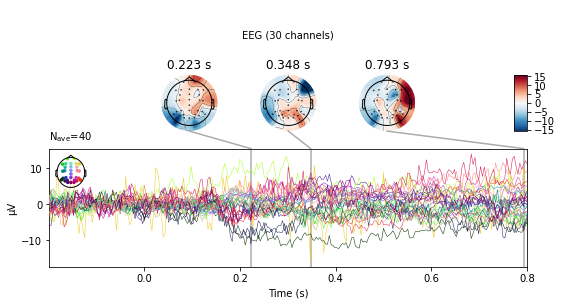

0 files missing from /home/chrei/venv/lib/python3.8/site-packages/mne/datasets/_fsaverage/root.txt in /home/chrei/mne_data/MNE-fsaverage-data
0 files missing from /home/chrei/venv/lib/python3.8/site-packages/mne/datasets/_fsaverage/bem.txt in /home/chrei/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /home/chrei/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : identity
Measurement data      : instance of Info
Conductor model   : /home/chrei/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/chrei/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.00

In [16]:
from mne.channels import compute_native_head_t, read_custom_montage

"""
TODO check if raw_f needed, but here raw because raw_f has only Pz channel
"""
# ValueError: EEG average reference is mandatory for inverse modeling, use set_eeg_reference method.
raw.set_eeg_reference(projection=True)

#get epochs
epochs = mne.Epochs(
        raw, evts, evts_dict_stim, tmin=epoch_tmin, tmax=epoch_tmax, baseline=baseline
)

#get evoked
target = epochs[["stimulus:{}{}".format(k, k) for k in [1, 2, 3, 4, 5]]].average()
distractor = epochs[
    [
        "stimulus:{}{}".format(k, j)
        for k in [1, 2, 3, 4, 5]
        for j in [1, 2, 3, 4, 5]
        if k != j
    ]
].average()
evoked = target  # trigger 1 in auditory/left
%matplotlib inline
evoked.plot_joint()




# get average src and bem
from mne.datasets import fetch_fsaverage
import os.path as op

fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

# plot to check alignment
"""
# RuntimeError: Could not load any valid 3D backend: pyvista, mayavi, notebook
fig = plot_alignment(
    evoked.info, trans=None, show_axes=True, surfaces='head-dense',
    subject=subject, subjects_dir=subjects_dir)
"""

fwd = mne.make_forward_solution(
    evoked.info, trans=None, src=src, bem=bem, verbose=True)



In [17]:
cov = mne.compute_covariance(epochs, tmax=0.)

Loading data for 8 events and 257 original time points ...
0 bad epochs dropped
Loading data for 9 events and 257 original time points ...
0 bad epochs dropped
Loading data for 7 events and 257 original time points ...
0 bad epochs dropped
Loading data for 13 events and 257 original time points ...
0 bad epochs dropped
Loading data for 3 events and 257 original time points ...
0 bad epochs dropped
Loading data for 6 events and 257 original time points ...
0 bad epochs dropped
Loading data for 8 events and 257 original time points ...
0 bad epochs dropped
Loading data for 7 events and 257 original time points ...
0 bad epochs dropped
Loading data for 9 events and 257 original time points ...
0 bad epochs dropped
Loading data for 10 events and 257 original time points ...
0 bad epochs dropped
Loading data for 13 events and 257 original time points ...
0 bad epochs dropped
Loading data for 5 events and 257 original time points ...
0 bad epochs dropped
Loading data for 8 events and 257 ori

In [18]:
# Compute the inverse and apply it:
inv = mne.minimum_norm.make_inverse_operator(
    evoked.info, fwd, cov, verbose=True)


Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 30 channels.
    30 out of 30 channels remain after picking
Selected 30 channels
Creating the depth weighting matrix...
    30 EEG channels
    limit = 20485/20484 = 2.621321
    scale = 38748.3 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 7e-14 (2.2e-16 eps * 30 dim * 10  max singular value)
    Estimated rank (eeg): 29
    EEG: rank 29 computed from 30 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of wh

In [19]:
stc = mne.minimum_norm.apply_inverse(evoked, inv)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 40
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 29 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.20 * stimulus:11 + 0.20 * stimulus:22 + 0.20 * stimulus:33 + 0.20 * stimulus:44 + 0.20 * stimulus:55"...
    Picked 30 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  79.3% variance
    Combining the current components...
    dSPM...
[done]


In [21]:
#mne.viz.set_3d_backend("notebook")
from pyvistaqt import BackgroundPlotter
%matplotlib inline
brain = stc.plot(subjects_dir=subjects_dir, initial_time=0.1)

Using pyvista 3d backend.

Using control points [ 7.91586152  9.15071092 15.84793011]


In [ ]:
raw.info

In [ ]:
epochs, evts, evts_dict_stim = epoching()

In [ ]:
"""# ensure all conditions have the same counts, as the ANOVA expects a fully balanced data matrix and 
# does not forgive imbalances that generously (risk of type-I error).
epochs.equalize_event_counts(evts_dict_stim) # TODO not sure if it's good that 100 epoches are droped

# Factor to down-sample the temporal dimension of the TFR computed by
# tfr_morlet.
decim = 2
frequencies = np.arange(7, 30, 3)  # define frequencies of interest
n_cycles = frequencies / frequencies[0]
zero_mean = False  # don't correct morlet wavelet to be of mean zero
# To have a true wavelet zero_mean should be True but here for illustration
# purposes it helps to spot the evoked response."""

"""from mne.time_frequency import tfr_morlet"""

"""import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet
from mne.stats import f_threshold_mway_rm, f_mway_rm, fdr_correction
from mne.datasets import sample"""

"""# Create TFR (time-frequency representations) for all conditions
epochs_power = list()
for condition in [epochs[k] for k in evts_dict_stim]:
    this_tfr = tfr_morlet(condition, frequencies, n_cycles=n_cycles,
                          decim=decim, average=False, zero_mean=zero_mean,
                          return_itc=False)
    this_tfr.apply_baseline(mode='ratio', baseline=(None, 0))
    this_power = this_tfr.data[:, 0, :, :]  # we only have one channel.
    epochs_power.append(this_power)"""

"""# Setup repeated measures ANOVA
# We will tell the ANOVA how to interpret the data matrix in terms of factors. 
# This is done via the factor levels argument which is a list of the number factor levels for each factor.
n_conditions = len(epochs.event_id)
n_replications = int(epochs.events.shape[0] / n_conditions)

factor_levels = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]  # number of levels in each factor
effects = 'A*B'  # this is the default signature for computing all effects
# Other possible options are 'A' or 'B' for the corresponding main effects
# or 'A:B' for the interaction effect only (this notation is borrowed from the
# R formula language)
n_frequencies = len(frequencies)
times = 1e3 * epochs.times[::decim]
n_times = len(times)"""

"""# Now we’ll assemble the data matrix and swap axes so the trial replications are the first dimension and the conditions are the second dimension.

data = np.swapaxes(np.asarray(epochs_power), 1, 0)
# reshape last two dimensions in one mass-univariate observation-vector
data = data.reshape(n_replications, n_conditions, n_frequencies * n_times)

# so we have replications * conditions * observations:
print(data.shape)
print(n_conditions)"""

"""# Now we’re ready to run our repeated measures ANOVA.

# Note. As we treat trials as subjects, the test only accounts for time locked responses,
# despite the ‘induced’ approach. For analysis for induced power at the group level averaged TRFs are required.
print('f_mway_rm')
fvals, pvals = f_mway_rm(data, factor_levels, effects=effects)

effect_labels = ['modality', 'location', 'modality by location']

# let's visualize our effects by computing f-images
for effect, sig, effect_label in zip(fvals, pvals, effect_labels):
    print('for')
    plt.figure()
    # show naive F-values in gray
    plt.imshow(effect.reshape(8, 211), cmap=plt.cm.gray, extent=[times[0],
               times[-1], frequencies[0], frequencies[-1]], aspect='auto',
               origin='lower')
    # create mask for significant Time-frequency locations
    effect = np.ma.masked_array(effect, [sig > .05])
    plt.imshow(effect.reshape(8, 211), cmap='RdBu_r', extent=[times[0],
               times[-1], frequencies[0], frequencies[-1]], aspect='auto',
               origin='lower')
    plt.colorbar()
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(r"Time-locked response for '%s' (%s)" % (effect_label, ch_name))
    plt.show()"""

# Source Space Localization